1. Environment Setup
Install -> langgraph langchain langchain-groq tavily-python python-dotenv

Create a .env file for your API keys:

GROQ_API_KEY=your_groq_api_key
TAVILY_API_KEY=your_tavily_api_key

In [1]:
# 2. Initialize LLM and Tools

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import time
from groq import RateLimitError

In [2]:
import arxiv
import requests
from bs4 import BeautifulSoup
from scholarly import scholarly

In [5]:
from typing import List 
# ArXiv Search Tool
def search_arxiv(query: str, max_results: int = 3) -> List[dict]:
    """Search ArXiv for research papers"""
    try:
        # Create a client with appropriate parameters
        client = arxiv.Client(
            page_size=10,
            delay_seconds=3,
            num_retries=3
        )

        # Create search object
        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.SubmittedDate,
            sort_order=arxiv.SortOrder.Descending
        )
        results = []
        # Use the client to get results
        for result in client.results(search):
            results.append({
                "title": result.title,
                "summary": result.summary,
                "authors": [author.name for author in result.authors],
                "published": result.published.strftime("%Y-%m-%d") if result.published else "Unknown",
                "pdf_url": result.pdf_url,
                "doi": result.entry_id,
                "source": "arXiv"
            })
            if len(results) >= max_results:
                break
        return results
    except Exception as e:
        print(f"ArXiv search error: {e}")
        return []
    
# PubMed Search Tool
def search_pubmed(query: str, max_results: int = 3) -> List[dict]:
    """Search PubMed for research articles"""
    try:
        base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
        params = {
            "db": "pubmed",
            "term": query,
            "retmode": "json",
            "retmax": max_results
        }
        response = requests.get(base_url, params=params)
        id_list = response.json()["esearchresult"]["idlist"]
        
        results = []
        for pubmed_id in id_list:
            summary_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
            summary_params = {
                "db": "pubmed",
                "id": pubmed_id,
                "retmode": "json"
            }
            summary_response = requests.get(summary_url, params=summary_params)
            article_data = summary_response.json()["result"][pubmed_id]
            
            results.append({
                "title": article_data.get("title", "No title"),
                "abstract": article_data.get("abstract", "No abstract"),
                "authors": [author["name"] for author in article_data.get("authors", [])],
                "published": article_data.get("pubdate", "Unknown"),
                "doi": article_data.get("elocationid", "No DOI"),
                "source": "PubMed"
            })
        return results
    except Exception as e:
        print(f"PubMed search error: {e}")
        return []


In [4]:
load_dotenv()

# Initialize LLM
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0
)

validation_llm = ChatGroq(
    model="moonshotai/kimi-k2-instruct",
    temperature=0
)

# Initialize Search Tool
search_tool = TavilySearchResults(max_results=3)

C:\Users\HP\AppData\Local\Temp\ipykernel_11508\2015665932.py:15: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=3)


In [6]:
# 3. Define Agent State

from typing import TypedDict, List, Annotated
import operator

class ResearchState(TypedDict):
    question: str
    search_results: List[str]
    drafted_content: str
    refined_answer: str
    follow_up_questions: List[str]
    research_depth: int
    max_depth: int
    validation_score: float  # Optional for quality assessment
    validation_feedback: str  # Optional for quality assessment
    needs_more_research: bool
    sources_used: List[str]  # Track which sources were used
    source_counts: dict 
    detailed_sources: List[dict]  # Add this line
    max_results: int  # Add this field
    

In [7]:
# Helper function for LLM requests with retry
def make_llm_request_with_retry(prompt, max_retries=3, specific_llm=None, timeout=30):
    # Use the provided LLM or default to the main LLM
    target_llm = specific_llm if specific_llm is not None else llm

    for attempt in range(max_retries):
        try:
            response = target_llm.invoke(prompt)
            return response
        except Exception as e:
            if "timeout" in str(e).lower() or "rate_limit" in str(e).lower() or "413" in str(e) or attempt < max_retries - 1:
                wait_time = 2 ** attempt
                print(f"API issue. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
            else:
                raise e

In [8]:
# Helper function to summarize content
def summarize_content(content: str, max_length: int = 500, source: str = "Unknown") -> str:
    """Summarize content with special handling for academic papers"""
    if len(content) <= max_length:
        return f"[{source}] {content}"
    
    # Special handling for academic papers
    if source in ["arXiv", "PubMed"]:
        prompt = f"""Summarize this academic content in {max_length} characters or less, focusing on:
        1. Key findings
        2. Methodology (if relevant)
        3. Conclusions
        
        Content:
        {content}

        Concise summary:"""
    else:
        prompt = f"""Summarize this content in {max_length} characters or less:
        
        {content}
        
        Summary:"""

    try:
        response = make_llm_request_with_retry(prompt)
        return f"[{source}] {response.content[:max_length]}"
    except:
        return f"[{source}] {content[:max_length]}..."
    

    

In [9]:
# Add this dictionary to explain each source type
SOURCE_DESCRIPTIONS = {
    "Web": "General web search results from various websites",
    "arXiv": "Academic pre-print papers from arXiv.org (physics, math, CS, etc.)",
    "PubMed": "Biomedical literature from the National Library of Medicine"
}

In [10]:
# Add this function to generate a source explanation
def generate_source_explanation(sources_used, source_counts):
    if not sources_used:
        return "No sources were used in this research."
    
    explanation = "\n\n## Information Sources\n"
    explanation += "This response was generated using information from the following sources:\n\n"
    
    for source in sources_used:
        count = source_counts.get(source, 0)
        description = SOURCE_DESCRIPTIONS.get(source, "Various online sources")
        explanation += f"- **{source}** ({count} {'result' if count == 1 else 'results'}): {description}\n"
    
    return explanation

In [11]:
def explain_sources_to_user(sources_used):
    if not sources_used:
        return "No specific sources were used in this research."
    
    explanation = "I gathered information from these sources:\n"
    
    for source in sources_used:
        if source == "Web":
            explanation += "• General web search: Various websites across the internet\n"
        elif source == "arXiv":
            explanation += "• arXiv: A repository of academic papers (especially physics, math, computer science)\n"
        elif source == "PubMed":
            explanation += "• PubMed: A database of biomedical research articles\n"
        else:
            explanation += f"• {source}: Various information sources\n"
    
    explanation += "\nEach source has different strengths: web search for general information, "
    explanation += "arXiv for academic pre-prints, and PubMed for medical research."
    
    return explanation

In [12]:
def generate_detailed_sources_list(detailed_sources):
    """Generate a detailed list of all sources used"""
    if not detailed_sources:
        return "No detailed source information available."
    
    output = "\n\n## Detailed Sources Reference\n"
    # Group by source type
    by_source = {}
    for source in detailed_sources:
        s_type = source.get("source_type", "Unknown")
        if s_type not in by_source:
            by_source[s_type] = []
        by_source[s_type].append(source)

    # Format each source type
    for source_type, sources in by_source.items():
        output += f"\n### {source_type}\n"
        for i, source in enumerate(sources, 1):
            if source_type == "arXiv":
                output += f"{i}. {source.get('title', 'Unknown title')}\n"
                output += f"   Authors: {', '.join(source.get('authors', []))}\n"
                output += f"   Published: {source.get('published', 'Unknown date')}\n"
                output += f"   URL: {source.get('url', 'No URL available')}\n"
                if source.get('doi'):
                    output += f"   DOI: {source.get('doi')}\n"
            elif source_type == "PubMed":
                output += f"{i}. {source.get('title', 'Unknown title')}\n"
                output += f"   Authors: {', '.join(source.get('authors', []))}\n"
                output += f"   Published: {source.get('published', 'Unknown date')}\n"
                if source.get('doi'):
                    output += f"   DOI: {source.get('doi')}\n"
            elif source_type == "Web":
                output += f"{i}. {source.get('title', 'Unknown title')}\n"
                output += f"   URL: {source.get('url', 'No URL available')}\n"
            
            # Add a preview of the content
            if source.get('content'):
                output += f"   Preview: {source.get('content')[:150]}...\n"
            
            output += "\n"
    
    return output



In [13]:
# 4. Create Graph Nodes

from langgraph.graph import StateGraph, END

# Define graph builder
builder = StateGraph(ResearchState)

# Modify your research node to use multiple sources:
def unified_search(query: str, max_results: int = 3) -> List[dict]:
    """Search multiple sources and return combined results with detailed metadata"""
    all_results = []

    print(f"DEBUG: Starting unified search for: {query}")  # Debug
    
    # Search Tavily (existing)
    try:
        print("DEBUG: Searching Tavily...")  # Debug
        tavily_results = search_tool.invoke({"query": query})
        print(f"DEBUG: Tavily results: {len(tavily_results)} items")
        
        for result in tavily_results:
            if isinstance(result, dict):  # Ensure it's a dictionary
                # Create a copy to avoid modifying the original
                result_copy = result.copy()
                result_copy["source"] = "Web"
                # Add detailed metadata for web results
                result_copy["detailed_info"] = {
                    "title": result_copy.get("title", "Unknown title"),
                    "url": result_copy.get("url", "No URL available"),
                    "content": result_copy.get("content", "")[:500] + "..." if result_copy.get("content") else "No content"
                    }
                all_results.append(result_copy)
            else:
                print(f"DEBUG: Skipping non-dict Tavily result: {result}")
    except Exception as e:
        print(f"Tavily search error: {e}")
        
    # Search ArXiv
    try:
        print("DEBUG: Searching ArXiv...")  # Debug
        arxiv_results = search_arxiv(query, max_results)
        print(f"DEBUG: ArXiv results: {len(arxiv_results)} items")

        for result in arxiv_results:
            if isinstance(result, dict):  # Ensure it's a dictionary
                # Create a copy to avoid modifying the original
                result_copy = result.copy()
                # Add detailed metadata for arXiv results
                result_copy["detailed_info"] = {
                    "title": result_copy.get("title", "Unknown title"),
                    "authors": result_copy.get("authors", []),
                    "published": result_copy.get("published", "Unknown date"),
                    "url": result_copy.get("pdf_url", "No URL available"),
                    "doi": result_copy.get("doi", "No DOI available"),
                    "content": result_copy.get("summary", "")[:500] + "..." if result_copy.get("summary") else "No abstract"
                }
                all_results.extend(result_copy)
            else:
                print(f"DEBUG: Skipping non-dict ArXiv result: {result}")
    except Exception as e:
        print(f"ArXiv search error in unified search: {e}")
    
    # Search PubMed
    try:
        print("DEBUG: Searching PubMed...")  # Debug
        pubmed_results = search_pubmed(query, max_results)
        print(f"DEBUG: PubMed results: {len(pubmed_results)} items")
        for result in pubmed_results:
            if isinstance(result, dict):  # Ensure it's a dictionary
                # Create a copy to avoid modifying the original
                result_copy = result.copy()
                # Add detailed metadata for PubMed results
                result_copy["detailed_info"] = {
                    "title": result_copy.get("title", "Unknown title"),
                    "authors": result_copy.get("authors", []),
                    "published": result_copy.get("published", "Unknown date"),
                    "doi": result_copy.get("doi", "No DOI available"),
                    "content": result_copy.get("abstract", "")[:500] + "..." if result_copy.get("abstract") else "No abstract"
                }
                all_results.extend(result_copy)
            else:
                print(f"DEBUG: Skipping non-dict PubMed result: {result}")  # Debug
    except Exception as e:
        print(f"PubMed search error in unified search: {e}")

    print(f"DEBUG: Unified search completed. Total results: {len(all_results)}")  # Debug
    
    return all_results

def unified_search(query: str, max_results: int = 3) -> List[dict]:
    """Search multiple sources and return combined results with detailed metadata"""
    all_results = []
    
    # Search Tavily (existing)
    try:
        tavily_results = search_tool.invoke({"query": query})
        for result in tavily_results:
            if isinstance(result, dict):
                # Create a new dictionary with all the necessary fields
                new_result = {
                    "title": result.get("title", "Unknown title"),
                    "url": result.get("url", "No URL available"),
                    "content": result.get("content", ""),
                    "source": "Web",
                    "detailed_info": {
                        "title": result.get("title", "Unknown title"),
                        "url": result.get("url", "No URL available"),
                        "content": result.get("content", "")[:500] + "..." if result.get("content") else "No content"
                    }
                }
                all_results.append(new_result)
    except Exception as e:
        print(f"Tavily search error: {e}")
        
    # Search ArXiv
    try:
        arxiv_results = search_arxiv(query, max_results)
        for result in arxiv_results:
            if isinstance(result, dict):
                # Create a new dictionary with all the necessary fields
                new_result = {
                    "title": result.get("title", "Unknown title"),
                    "summary": result.get("summary", ""),
                    "authors": result.get("authors", []),
                    "published": result.get("published", "Unknown date"),
                    "pdf_url": result.get("pdf_url", "No URL available"),
                    "doi": result.get("doi", "No DOI available"),
                    "source": "arXiv",
                    "detailed_info": {
                        "title": result.get("title", "Unknown title"),
                        "authors": result.get("authors", []),
                        "published": result.get("published", "Unknown date"),
                        "url": result.get("pdf_url", "No URL available"),
                        "doi": result.get("doi", "No DOI available"),
                        "content": result.get("summary", "")[:500] + "..." if result.get("summary") else "No abstract"
                    }
                }
                all_results.append(new_result)
    except Exception as e:
        print(f"ArXiv search error in unified search: {e}")
    
    # Search PubMed
    try:
        pubmed_results = search_pubmed(query, max_results)
        for result in pubmed_results:
            if isinstance(result, dict):
                # Create a new dictionary with all the necessary fields
                new_result = {
                    "title": result.get("title", "Unknown title"),
                    "abstract": result.get("abstract", ""),
                    "authors": result.get("authors", []),
                    "published": result.get("published", "Unknown date"),
                    "doi": result.get("doi", "No DOI available"),
                    "source": "PubMed",
                    "detailed_info": {
                        "title": result.get("title", "Unknown title"),
                        "authors": result.get("authors", []),
                        "published": result.get("published", "Unknown date"),
                        "doi": result.get("doi", "No DOI available"),
                        "content": result.get("abstract", "")[:500] + "..." if result.get("abstract") else "No abstract"
                    }
                }
                all_results.append(new_result)
    except Exception as e:
        print(f"PubMed search error in unified search: {e}")
    
    return all_results

# Node 1: Research - Search the web 
# Modify your research node to use the unified search:
def research_node(state: ResearchState):
    try:

        # Get results from all sources with detailed metadata 
        all_results = unified_search(state["question"], max_results=state.get("max_results", 3))

        # Filter out non-dictionary results
        filtered_results = [result for result in all_results if isinstance(result, dict)]
        print(f"DEBUG: Filtered {len(all_results) - len(filtered_results)} non-dict results")

        if not filtered_results:
            print("All search sources failed, using fallback strategy")
            return {
                "search_results": ["No search results available"],
                "sources_used": [],
                "source_counts": {},
                "detailed_sources": []
            }

        # Track which sources were used with counts
        source_counts = {}
        detailed_sources = []  # Store detailed source information

        for result in filtered_results:
            source = result.get("source", "Unknown")
            source_counts[source] = source_counts.get(source, 0) + 1

            # Store detailed source information
            if "detailed_info" in result:
                detailed_info = result["detailed_info"].copy()
                detailed_info["source_type"] = source
                detailed_sources.append(detailed_info)
            else:
                # Create detailed info from the result itself if not already present

                detailed_info = {
                    "title": result.get("title", "Unknown title"),
                    "url": result.get("url", result.get("pdf_url", "No URL available")),
                    "content": result.get("content", result.get("summary", result.get("abstract", "")))[:500] + "...",
                    "source_type": source
                }
                if "authors" in result:
                    detailed_info["authors"] = result.get("authors", [])
                if "published" in result:
                    detailed_info["published"] = result.get("published", "Unknown date")
                if "doi" in result:
                    detailed_info["doi"] = result.get("doi", "No DOI available")
                detailed_sources.append(detailed_info)

        # Summarize content with clear source attribution
        summarized_results = []
        for result in filtered_results:
            content = result.get("content", "") or result.get("summary", "") or result.get("abstract", "")
            source = result.get("source", "Unknown")

            # Create a more descriptive source label
            if source in SOURCE_DESCRIPTIONS:
                source_label = f"{source} ({SOURCE_DESCRIPTIONS[source]})"
            else:
                source_label = source
                
            summarized = summarize_content(content)
            summarized_with_source = f"[Source: {source_label}] {summarized}"
            summarized_results.append(summarized_with_source)

        return {
            "search_results": summarized_results,
            "sources_used": list(source_counts.keys()),
            "source_counts": source_counts,
            "detailed_sources": detailed_sources
        }
    except Exception as e:
        print(f"Research node error: {e}")
        import traceback
        traceback.print_exc()
        return {
            "search_results": ["Research failed due to technical issues"],
            "sources_used": [],
            "source_counts": {},
            "detailed_sources": []
        }
    
def research_node(state: ResearchState):
    try:
        # Get results from all sources
        all_results = unified_search(state["question"], max_results=state.get("max_results", 3))
        
        # Filter out non-dictionary results
        valid_results = [result for result in all_results if isinstance(result, dict)]
        
        if not valid_results:
            print("All search sources failed, using fallback strategy")
            return {
                "search_results": ["No search results available"],
                "sources_used": [],
                "source_counts": {},
                "detailed_sources": []
            }

        # Track which sources were used with counts
        source_counts = {}
        detailed_sources = []
        summarized_results = []

        for result in valid_results:
            source = result.get("source", "Unknown")
            source_counts[source] = source_counts.get(source, 0) + 1

            # Store detailed source information
            if "detailed_info" in result:
                detailed_info = result["detailed_info"].copy()
                detailed_info["source_type"] = source
                detailed_sources.append(detailed_info)

            # Summarize content with clear source attribution
            content = result.get("content", "") or result.get("summary", "") or result.get("abstract", "")
            
            if source in SOURCE_DESCRIPTIONS:
                source_label = f"{source} ({SOURCE_DESCRIPTIONS[source]})"
            else:
                source_label = source
                
            summarized = summarize_content(content)
            summarized_with_source = f"[Source: {source_label}] {summarized}"
            summarized_results.append(summarized_with_source)

        return {
            "search_results": summarized_results,
            "sources_used": list(source_counts.keys()),
            "source_counts": source_counts,
            "detailed_sources": detailed_sources
        }
    except Exception as e:
        print(f"Research node error: {e}")
        import traceback
        traceback.print_exc()
        return {
            "search_results": ["Research failed due to technical issues"],
            "sources_used": [],
            "source_counts": {},
            "detailed_sources": []
        }
    
# Node 2: Draft - Initial content generation
def draft_node(state: ResearchState):
    context = "\n\n".join(state["search_results"])

    # Truncate context if too long
    if len(context) > 4000:  # Slightly larger context window for academic content
        context = context[:4000] + "..."

    # Special prompt for academic questions
    if any(source in state.get("sources_used", []) for source in ["arXiv", "PubMed"]):
        prompt = f"""Research and answer this academic question: {state['question']}
        
        Context from academic sources:
        {context}
        
        Provide a comprehensive, well-structured answer with:
        1. Key findings from the research
        2. Methodologies used (if relevant)
        3. Limitations or areas for further research
        4. Proper citations to sources
        
        Answer:"""
    else:
        prompt = f"""Research and answer: {state['question']}
        
        Context:
        {context}
        
        Provide a comprehensive but concise answer:"""
    
    response = make_llm_request_with_retry(prompt)
    return {"drafted_content": response.content}

# Node 3: Refine - Improve the answer
# Modify the refine_node to include source attribution in the final answer

def refine_node(state: ResearchState):
    # Truncate content if too long
    content = state["drafted_content"]
    if len(content) > 2000:
        content = content[:2000] + "..."

    # Add source information to the refinement prompt
    source_info = generate_source_explanation(
        state.get("sources_used", []), 
        state.get("source_counts", {})
    )

    # Generate detailed sources list
    detailed_sources_list = generate_detailed_sources_list(state.get("detailed_sources", []))
    
    prompt = f"""Refine this answer: {content}
    
    Ensure it's:
    1. Well-structured
    2. Contains citations with clear source attribution
    3. Addresses all aspects of: {state['question']}
    4. Includes a clear explanation of information sources
    
    Also, add this source information to the end of your response:{source_info}
    
    And add this detailed source list:{detailed_sources_list}

    Improved version:"""
    
    response = make_llm_request_with_retry(prompt)
    return {"refined_answer": response.content}

def generate_follow_ups_node(state: ResearchState):

    if state["research_depth"] >= state["max_depth"]:
        return {"follow_up_questions": []}
    
    content = state["drafted_content"]
    if len(content) > 1500:
        content = content[:1500] + "..."

    # Different prompts based on sources used
    if any(source in state.get("sources_used", []) for source in ["arXiv", "PubMed"]):
        prompt = f"""Based on this academic research, generate 2-3 specific follow-up questions 
        that would help provide a more comprehensive answer to: {state['question']}
        
        Current research:
        {content}

        Focus on:
        1. Methodological questions
        2. Gaps in the current research
        3. Applications or implications of the findings
        
        Generate specific, answerable follow-up questions:"""
    else:
        prompt = f"""Based on the current research findings, generate 2-3 specific follow-up questions 
        that would help provide a more comprehensive answer to: {state['question']}
        
        Current research:
        {content}
        
        Generate specific, answerable follow-up questions:"""
    
    response = make_llm_request_with_retry(prompt)

    # Parse the response to extract questions
    questions = []
    for line in response.content.split('\n'):
        if line.strip() and any(char.isdigit() or char in ['-', '*'] for char in line[:3]):
            questions.append(line.split('.', 1)[-1].strip())
    
    return {"follow_up_questions": questions[:2]}
 
    

def research_follow_ups_node(state: ResearchState):
    if not state["follow_up_questions"] or state["research_depth"] >= state["max_depth"]:
        return {"search_results": state["search_results"]}
    
    all_results = state["search_results"].copy()
    source_counts = state.get("source_counts", {}).copy()
    detailed_sources = state.get("detailed_sources", []).copy()  # Copy detailed sources

    # Ensure web search is tracked in source counts
    if "Web" not in source_counts:
        source_counts["Web"] = 0

    for question in state["follow_up_questions"]:
        results = search_tool.invoke({"query": question})
        for result in results:
            all_results.append(summarize_content(result["content"], source="Web"))
            source_counts["Web"] = source_counts.get("Web", 0) + 1

            # Add detailed information for web results
            detailed_info = {
                "source_type": "Web",
                "title": result.get("title", "Unknown title"),
                "url": result.get("url", "No URL available"),
                "content": result.get("content", "")[:500] + "..." if result.get("content") else "No content"
            }
            detailed_sources.append(detailed_info)

    
    return {
        "search_results": all_results,
        "research_depth": state["research_depth"] + 1,
        "sources_used": list(set(state.get("sources_used", []) + ["Web"])),
        "source_counts": source_counts,
        "detailed_sources": detailed_sources  # Preserve detailed sources
    }


import re 
# New validation node
def validation_node(state: ResearchState):

    # Skip validation if we've already done it
    if state.get("validation_score", 0) > 0.6:
        return {"needs_more_research": False}
    
    # Different validation criteria for academic content
    if any(source in state.get("sources_used", []) for source in ["arXiv", "PubMed"]):
        prompt = f"""Evaluate the quality of this academic research answer for: {state['question']}
        
        Answer to evaluate:
        {state['refined_answer']}
        
        Please evaluate based on these academic criteria:
        1. Accuracy of scientific concepts
        2. Proper interpretation of research findings
        3. Recognition of limitations in the cited studies
        4. Appropriate citation of sources
        5. Clarity of explanation for complex concepts

        Provide:
        - A score from 0.0 to 1.0
        - Specific feedback on what could be improved
        - A boolean indicating if more research is needed
        
        Format your response as:
        Score: [0.0-1.0]
        Feedback: [your feedback]
        More Research Needed: [true/false]"""

    else:
        prompt = f"""Evaluate the quality of this research answer for the question: {state['question']}
        
        Answer to evaluate:
        {state['refined_answer']}
        
        Please evaluate based on these criteria:
        1. Completeness (does it address all aspects of the question?)
        2. Accuracy (is the information factually correct?)
        3. Depth (does it provide sufficient detail?)
        4. Structure (is it well-organized?)
        5. Citation quality (are sources properly referenced?)
        
        Provide:
        - A score from 0.0 to 1.0
        - Specific feedback on what could be improved
        - A boolean indicating if more research is needed
        
        Format your response as:
        Score: [0.0-1.0]
        Feedback: [your feedback]
        More Research Needed: [true/false]"""
    try:
        response = make_llm_request_with_retry(prompt, specific_llm=validation_llm)
        content = response.content
        #print(f"DEBUG: Validation LLM response: {content}")  # Debug logging to see the raw response

        # Parse the response with regex for robustness
        score = 0.5  # Default score if parsing fails
        feedback = "No specific feedback provided"
        needs_more_research = False
        
        # Extract score using regex
        score_match = re.search(r"Score:\s*([0-9.]+)", content)
        if score_match:
            try:
                score = float(score_match.group(1))
            except ValueError:
                pass  # Keep default score if conversion fails
        
        # Extract feedback using regex
        feedback_match = re.search(r"Feedback:\s*(.*?)(?=More Research Needed:|$)", content, re.DOTALL)
        if feedback_match:
            feedback = feedback_match.group(1).strip()
        else:
            # Fallback: try to find Feedback without lookahead
            if "Feedback:" in content:
                feedback = content.split("Feedback:")[1].split("More Research Needed:")[0].strip()
        
        # Extract research recommendation using regex
        research_match = re.search(r"More Research Needed:\s*(true|false|yes|no)", content, re.IGNORECASE)
        if research_match:
            research_str = research_match.group(1).lower()
            needs_more_research = research_str in ["true", "yes"]
        else:
            # Fallback: check for the string
            if "More Research Needed:" in content:
                research_str = content.split("More Research Needed:")[1].strip().lower()
                needs_more_research = "true" in research_str or "yes" in research_str
        
        return {
            "validation_score": score,
            "validation_feedback": feedback,
            "needs_more_research": needs_more_research and state["research_depth"] < state["max_depth"]
        }
    except Exception as e:
        print(f"Validation error: {e}")
        return {
            "validation_score": 0.5,
            "validation_feedback": f"Validation failed: {str(e)}",
            "needs_more_research": False
        }

        
# New research improvement node
def improve_research_node(state: ResearchState):
    if not state["needs_more_research"]:
        return {"follow_up_questions": []}
    
    prompt = f"""Based on this validation feedback, generate specific follow-up research questions:
    
    Original question: {state['question']}
    Current answer: {state['refined_answer']}
    Validation feedback: {state['validation_feedback']}
    
    Generate 2-3 specific research questions that would address the validation feedback:"""

    response = make_llm_request_with_retry(prompt)

    # Parse the response to extract questions
    questions = []
    for line in response.content.split('\n'):
        if line.strip() and any(char.isdigit() or char in ['-', '*'] for char in line[:3]):
            questions.append(line.split('.', 1)[-1].strip())
    
    return {"follow_up_questions": questions[:2]}  # Limit to 2 questions
        
def safe_api_call(func, *args, **kwargs):
    """Wrapper for API calls with error handling and rate limiting"""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            if "rate_limit" in str(e).lower() or "429" in str(e):
                wait_time = 2 ** attempt
                print(f"Rate limited. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
            else:
                print(f"API call error: {e}")
                return None
    return None

def search_arxiv(query: str, max_results: int = 3) -> List[dict]:
    """Search ArXiv with error handling"""
    return safe_api_call(_search_arxiv_impl, query, max_results)

def _search_arxiv_impl(query: str, max_results: int = 3) -> List[dict]:
    """Search ArXiv for research papers"""
    try:
        # Create a client with appropriate parameters
        client = arxiv.Client(
            page_size=10,
            delay_seconds=3,
            num_retries=3
        )  
        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.SubmittedDate,
            sort_order=arxiv.SortOrder.Descending
        )
        results = []
        for result in client.results(search): # Use client.results()
            results.append({
                "title": result.title,
                "summary": result.summary,
                "authors": [author.name for author in result.authors],
                "published": result.published.strftime("%Y-%m-%d") if result.published else "Unknown",
                "pdf_url": result.pdf_url,
                "doi": result.entry_id,
                "source": "arXiv"
            })
            if len(results) >= max_results:
                break
        return results
    except Exception as e:
        print(f"ArXiv search error: {e}")
        return []

In [14]:
# Add nodes to graph
builder.add_node("research", research_node)
builder.add_node("draft", draft_node)
builder.add_node("refine", refine_node)
builder.add_node("generate_follow_ups", generate_follow_ups_node)
builder.add_node("research_follow_ups", research_follow_ups_node)
builder.add_node("validation", validation_node)
builder.add_node("improve_research", improve_research_node)


In [15]:
# 5. Define Graph Structure

# Set entry point
builder.set_entry_point("research")

# Create edges
builder.add_edge("research", "draft")
builder.add_edge("draft", "generate_follow_ups")

def should_continue_research(state: ResearchState):
    if state["follow_up_questions"] and state["research_depth"] < state["max_depth"]:
        return "research_follow_ups"
    return "refine"

builder.add_conditional_edges(
    "generate_follow_ups",
    should_continue_research,
    {
        "research_follow_ups": "research_follow_ups",
        "refine": "refine"
    }
)

builder.add_edge("research_follow_ups", "draft")
builder.add_edge("refine", "validation")

# Conditional edge for validation
def should_improve_research(state: ResearchState):
    if state["needs_more_research"]:
        return "improve_research"
    return END

builder.add_conditional_edges(
    "validation",
    should_improve_research,
    {
        "improve_research": "improve_research",
        END: END
    }
)

builder.add_edge("improve_research", "research_follow_ups")

# Compile graph
research_graph = builder.compile()

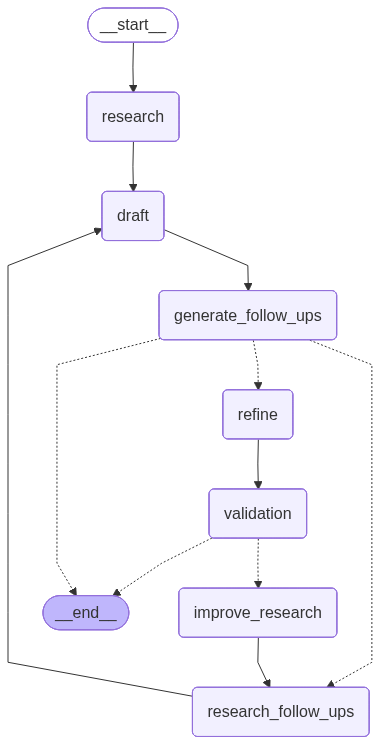

In [16]:
research_graph

In [18]:
def comprehensive_test():
    """Comprehensive test of the deep research agent with academic sources"""
    print("=" * 60)
    print("DEEP RESEARCH AGENT COMPREHENSIVE TEST")
    print("=" * 60)
    
    # Test 1: Individual source functionality
    print("\n1. TESTING INDIVIDUAL SOURCE FUNCTIONALITY")
    print("-" * 40)
    
    test_question = "Explain how transformer architectures like GPT-4 are being used in biomedical research for drug discovery, including recent breakthroughs and limitations."
    
    # Test ArXiv search
    print("\nTesting ArXiv search...")
    arxiv_results = search_arxiv(test_question, max_results=2)
    print(f"ArXiv results: {len(arxiv_results)}")
    if arxiv_results:
        print(f"First result title: {arxiv_results[0].get('title', 'No title')[:50]}...")
        print(f"First result source: {arxiv_results[0].get('source', 'Unknown')}")
    
    # Test PubMed search
    print("\nTesting PubMed search...")
    pubmed_results = search_pubmed(test_question, max_results=2)
    print(f"PubMed results: {len(pubmed_results)}")
    if pubmed_results:
        print(f"First result title: {pubmed_results[0].get('title', 'No title')[:50]}...")
        print(f"First result source: {pubmed_results[0].get('source', 'Unknown')}")
    
    # Test unified search
    print("\nTesting unified search...")
    unified_results = unified_search(test_question, max_results=2)
    print(f"Unified results: {len(unified_results)}")
    
    # Count results by source
    source_counts = {}
    for result in unified_results:
        if isinstance(result, dict):  # Check if it's a dictionary
            source = result.get("source", "Unknown")
            source_counts[source] = source_counts.get(source, 0) + 1
    print(f"Results by source: {source_counts}")
    
    # Test 2: Research node functionality
    print("\n\n2. TESTING RESEARCH NODE")
    print("-" * 40)
    
    test_state = {
        "question": test_question,
        "search_results": [],
        "drafted_content": "",
        "refined_answer": "",
        "follow_up_questions": [],
        "research_depth": 0,
        "max_depth": 2,
        "validation_score": 0.0,
        "validation_feedback": "",
        "needs_more_research": False,
        "sources_used": [],
        "source_counts": {},
        "detailed_sources": [],
        "max_results": 3
    }
    
    research_result = research_node(test_state)
    print(f"Research node completed with {len(research_result.get('search_results', []))} summarized results")
    print(f"Sources used: {research_result.get('sources_used', [])}")
    
    # Display a sample of the summarized results
    if research_result.get('search_results'):
        print("\nSample summarized result:")
        sample_result = research_result['search_results'][0]
        print(f"{sample_result[:100]}...")
    
    # Test 3: Full graph execution
    print("\n\n3. TESTING FULL GRAPH EXECUTION")
    print("-" * 40)
    
    print("Executing full research graph (this may take a few minutes)...")
    
    # Execute the full research graph
    final_state = research_graph.invoke({
        "question": test_question,
        "search_results": [],
        "drafted_content": "",
        "refined_answer": "",
        "follow_up_questions": [],
        "research_depth": 0,
        "max_depth": 2,  # Limit depth for testing
        "validation_score": 0.0,
        "validation_feedback": "",
        "needs_more_research": False,
        "sources_used": [],
        "source_counts": {},  # Add this line
        "detailed_sources": [],
        "max_results": 3
    })
    
    # Display results
    print("\nFINAL RESEARCH RESULTS:")
    print("=" * 40)
    print(f"Research depth achieved: {final_state.get('research_depth', 0)}")
    print(f"Final validation score: {final_state.get('validation_score', 0.0):.2f}")
    print("\nSOURCES USED:")
    print("-" * 20)
    sources_used = final_state.get('sources_used', [])
    source_counts = final_state.get('source_counts', {}) 

    if not sources_used:
        print("No sources were used in this research")
    else:
        for source in sources_used:
            count = source_counts.get(source, 0)
            description = SOURCE_DESCRIPTIONS.get(source, "Various online sources")
            print(f"- {source}: {count} results ({description})")

    print("\nVALIDATION FEEDBACK:")
    print("-" * 20)
    print(final_state.get('validation_feedback', 'No feedback available'))
    
    print("\nREFINED ANSWER:")
    print("-" * 20)
    print(final_state.get('refined_answer', 'No answer generated'))
    
    # Test 4: Error handling simulation
    print("\n\n4. TESTING ERROR HANDLING")
    print("-" * 40)
    
    # Test with a query that might cause issues
    error_test_question = "Explain quantum flux capacitance in multidimensional string theory"
    
    print(f"Testing with complex query: {error_test_question}")
    
    try:
        error_results = unified_search(error_test_question, max_results=1)
        print(f"Error test results: {len(error_results)}")
        print("Error handling test passed - no crashes occurred")
    except Exception as e:
        print(f"Error handling test failed: {e}")
    
    # Test 5: Performance metrics
    print("\n\n5. PERFORMANCE METRICS")
    print("-" * 40)
    
    # Note: You would need to add timing to your functions for this
    print("Performance metrics would include:")
    print("- Time taken for each research phase")
    print("- Number of API calls made")
    print("- Success rate of each data source")
    print("(Implement timing decorators for detailed metrics)")
    
    print("\n" + "=" * 60)
    print("TEST COMPLETED")
    print("=" * 60)

# Run the comprehensive test
comprehensive_test()

DEEP RESEARCH AGENT COMPREHENSIVE TEST

1. TESTING INDIVIDUAL SOURCE FUNCTIONALITY
----------------------------------------

Testing ArXiv search...
ArXiv results: 2
First result title: Standard Model Baryon Number Violation at Zero Tem...
First result source: arXiv

Testing PubMed search...
PubMed results: 0

Testing unified search...
Unified results: 5
Results by source: {'Web': 3, 'arXiv': 2}


2. TESTING RESEARCH NODE
----------------------------------------
Research node completed with 6 summarized results
Sources used: ['Web', 'arXiv']

Sample summarized result:
[Source: Web (General web search results from various websites)] [Unknown] The most recent upgrade, ...


3. TESTING FULL GRAPH EXECUTION
----------------------------------------
Executing full research graph (this may take a few minutes)...

FINAL RESEARCH RESULTS:
Research depth achieved: 2
Final validation score: 0.78

SOURCES USED:
--------------------
- arXiv: 3 results (Academic pre-print papers from arXiv.org (phys

In [19]:
# Test function
def test_academic_integration():
    """Test the integration of academic sources"""
    test_question = "Explain recent breakthroughs in CRISPR technology"
    
    # Test ArXiv search
    arxiv_results = search_arxiv(test_question, max_results=1)
    print("ArXiv results:", len(arxiv_results))
    
    # Test PubMed search
    pubmed_results = search_pubmed(test_question, max_results=1)
    print("PubMed results:", len(pubmed_results))
    
    # Test unified search
    unified_results = unified_search(test_question, max_results=2)
    print("Unified results:", len(unified_results))
    
    # Test with the full graph
    test_state = {
        "question": test_question,
        "search_results": [],
        "drafted_content": "",
        "refined_answer": "",
        "follow_up_questions": [],
        "research_depth": 0,
        "max_depth": 2,
        "validation_score": 0.0,
        "validation_feedback": "",
        "needs_more_research": False,
        "sources_used": []
    }
    
    research_result = research_node(test_state)
    print("Research node completed with sources:", research_result.get("sources_used", []))

# Run test
test_academic_integration()

C:\Users\HP\AppData\Local\Temp\ipykernel_5760\449781366.py:288: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


ArXiv results: 1
PubMed results: 1


C:\Users\HP\AppData\Local\Temp\ipykernel_5760\449781366.py:288: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Unified results: 7


C:\Users\HP\AppData\Local\Temp\ipykernel_5760\449781366.py:288: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Research node completed with sources: ['PubMed', 'Web', 'arXiv']
